# **MODS206 - Data analysis in economics 2 - Applied Econometrics**

### Authors:
* **Vinicius Mori**
* **Guilherme Kenzo Yamaguti**
* **Gustavo Hess**
* **Luiz Fonteles**
* **Fredo Antonino**

---

## **Imports and dataset loading**
#### We are using a pre-merged dataset (merged_data.xlsx), which combines the main traffic data
#### from dailyGrouping.feather with demographic information from cityInfo.csv using the 'city' key.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Load the merged dataset
df = pd.read_excel("merged_data.xlsx")

# Convert the 'date' column to datetime format
df["date"] = pd.to_datetime(df["date"])

## **Step 1: Explore global patterns to detect anomalies**
#### Computing the mean and the standard deviation per city. This helps identify whether any city stands out in its behavior — for example, in terms of average speed or variation.

In [ ]:
df_mean = df.groupby("city").mean(numeric_only=True).drop(columns=["station", "hour", "treated", "treated_time"])
df_std = df.groupby("city").std(numeric_only=True).drop(columns=["station", "hour", "treated", "treated_time"])

print("City-level Means:")
display(df_mean)

print("City-level Standard Deviations:")
display(df_std)

City-level Means:


,weather,dow,speed,vehicleType,energyConsumption,trafficCongestion,carCrash,pedestrianDeath,size,population,popDensity
city,,,,,,,,,,,
1,2.019133,4.02459,33.488319,2.250325,9.536293,2.942866,0.002470,0.000332,192.0,379909.0,1978.692708
2,2.005452,4.02459,39.500511,2.249893,8.566576,2.973074,0.002960,0.000396,91.0,453991.0,4988.912088
3,2.055621,4.02459,39.502021,2.250495,8.567277,2.156347,0.002098,0.000284,363.0,271008.0,746.578512
4,2.056869,4.02459,39.499802,2.248443,8.564627,1.135999,0.001175,0.000118,454.0,152110.0,335.044053
5,2.055746,4.02459,39.507055,2.249268,8.564909,1.000000,0.000986,0.000148,394.0,52620.0,133.553299
6,2.023467,4.02459,39.497802,2.250025,8.567123,2.905797,0.002891,0.000374,183.0,303659.0,1659.338798


City-level Standard Deviations:


,weather,dow,speed,vehicleType,energyConsumption,trafficCongestion,carCrash,pedestrianDeath,size,population,popDensity
city,,,,,,,,,,,
1,0.183170,1.986266,7.366511,0.011356,1.187710,0.047259,0.000756,0.000220,0.0,0.0,8.466067e-14
2,0.189939,1.986266,0.050473,0.010358,0.015779,0.033344,0.000551,0.000197,0.0,0.0,0.000000e+00
3,0.186384,1.986266,0.089483,0.019036,0.028136,0.692008,0.001029,0.000285,0.0,0.0,0.000000e+00
4,0.192692,1.986266,0.143905,0.026800,0.040574,0.169317,0.001141,0.000297,0.0,0.0,0.000000e+00
5,0.195127,1.986266,0.212674,0.039408,0.062132,0.000000,0.001240,0.000483,0.0,0.0,0.000000e+00
6,0.186074,1.986266,0.060237,0.012233,0.018835,0.071653,0.000660,0.000222,0.0,0.0,0.000000e+00


### Based on the descriptive statistics above, we note that city 1 has a significantly lower average speed and a much higher standard deviation in speed compared to the others. This suggests that city 1 might have undergone some internal change — possibly a policy intervention.


# **Step 2: Visualize weekly evolution of key metrics across all cities**

#### To confirm that only city 1 experienced structural changes, we'll plot key metrics over time by city.

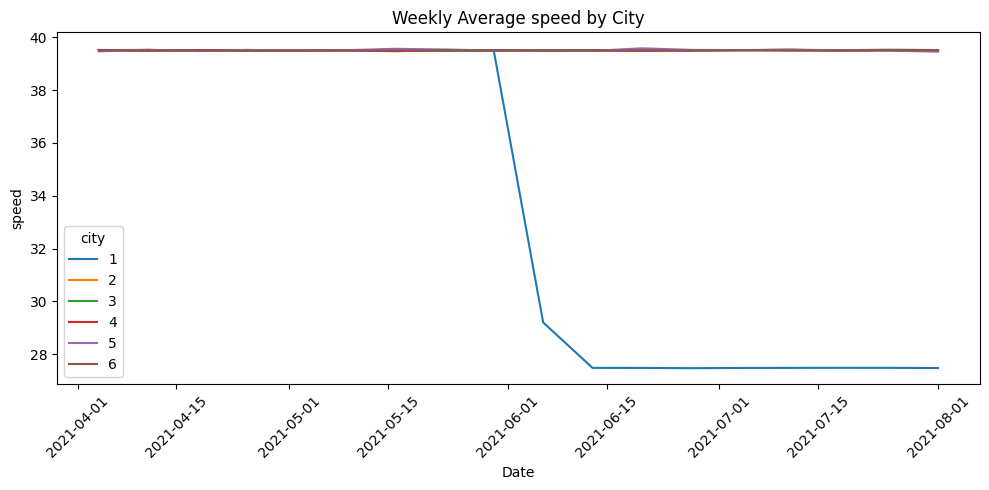

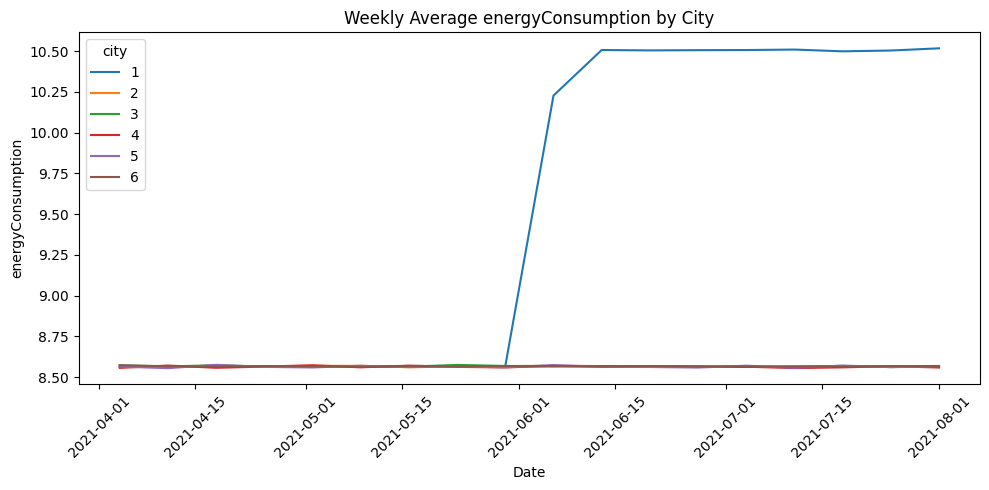

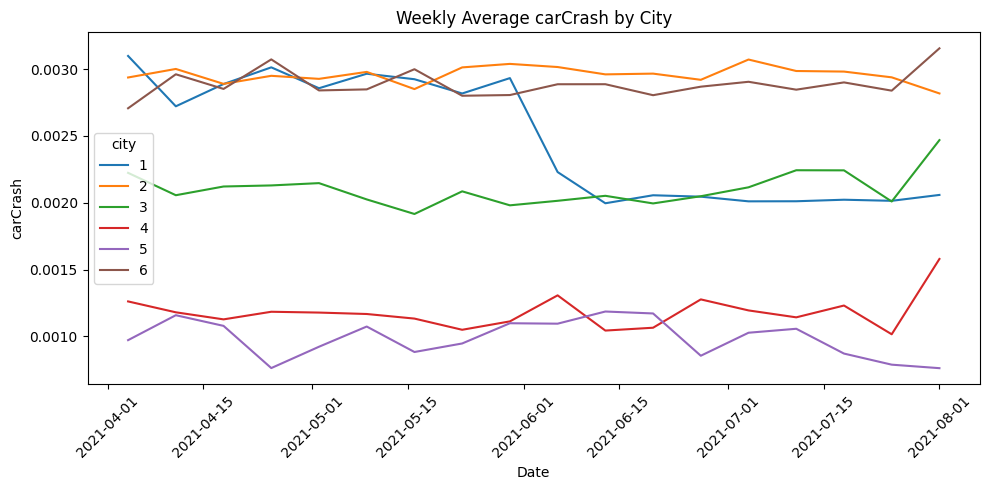

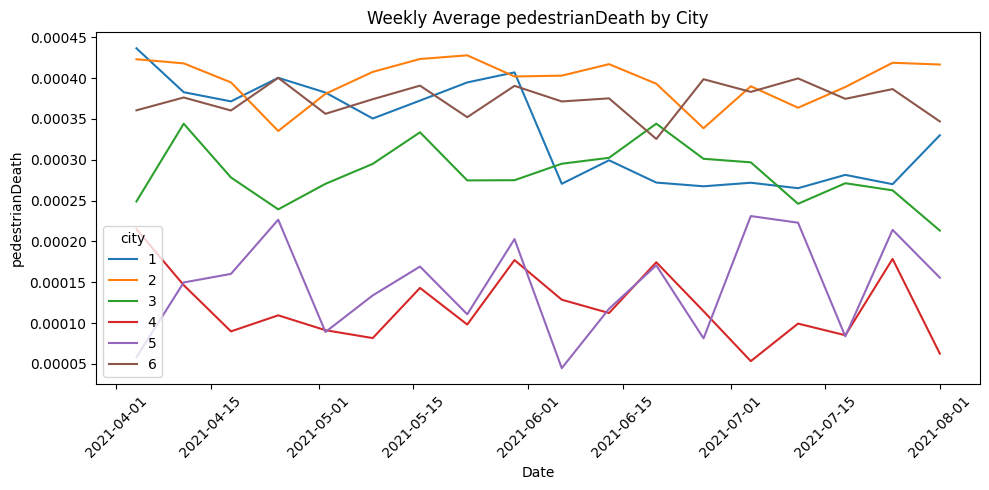

In [ ]:
df_weekly = df.groupby(["city", pd.Grouper(key="date", freq="W")]).mean(numeric_only=True).reset_index()

metrics_to_plot = ["speed", "energyConsumption", "carCrash", "pedestrianDeath"]

for var in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_weekly, x="date", y=var, hue="city", palette="tab10")
    plt.title(f"Weekly Average {var} by City")
    plt.ylabel(var)
    plt.xlabel("Date")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### These plots reveal that only city 1 experienced sharp drops in speed and simultaneous increases in energy consumption, along with reductions in crash and fatality metrics — supporting the hypothesis of a local policy intervention.

# **Step 3: Focus analysis on city 1 for deeper investigation**
#### Since city 1 stands out in both average and variability, we now zoom in to examine its trends in more detail. We'll observe how speed, energy consumption, and traffic metrics evolved over time in city 1. This should reveal any structural shifts in behavior.

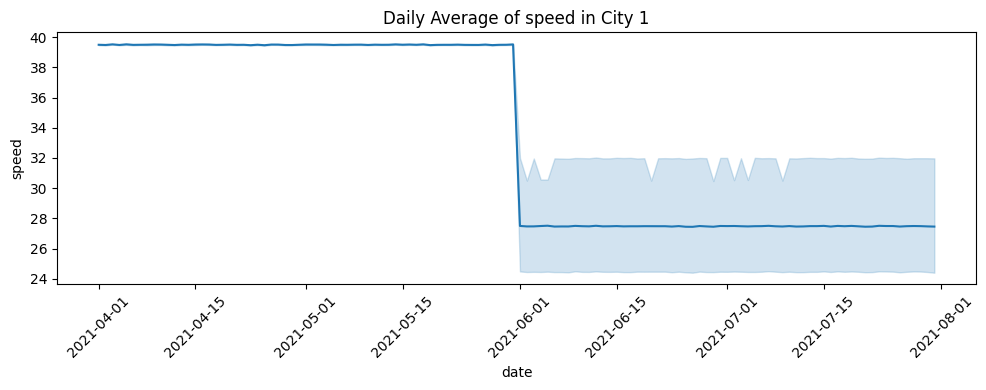

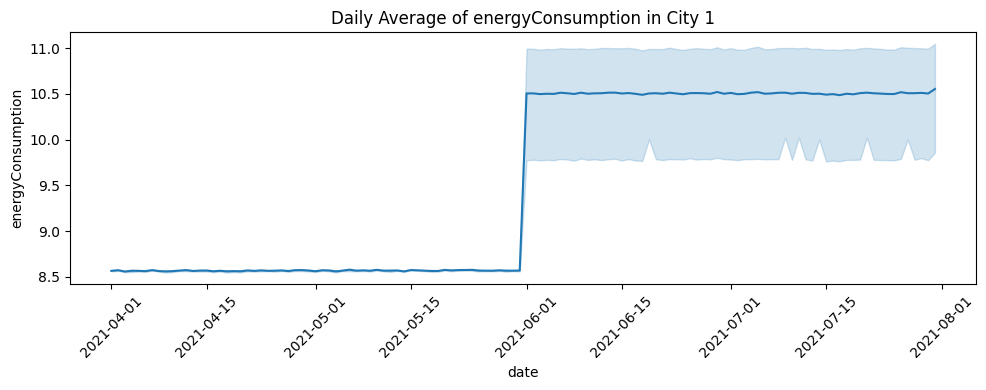

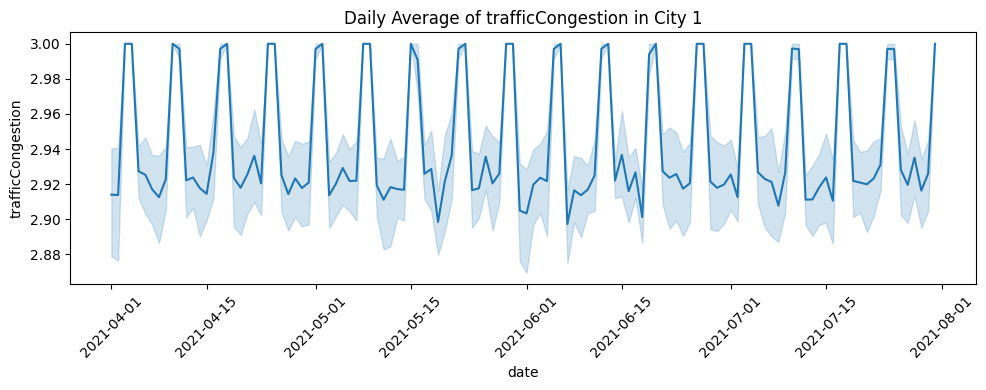

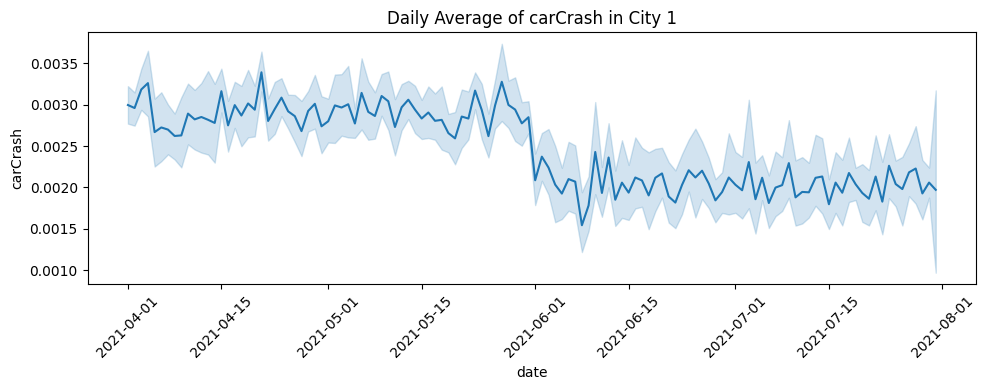

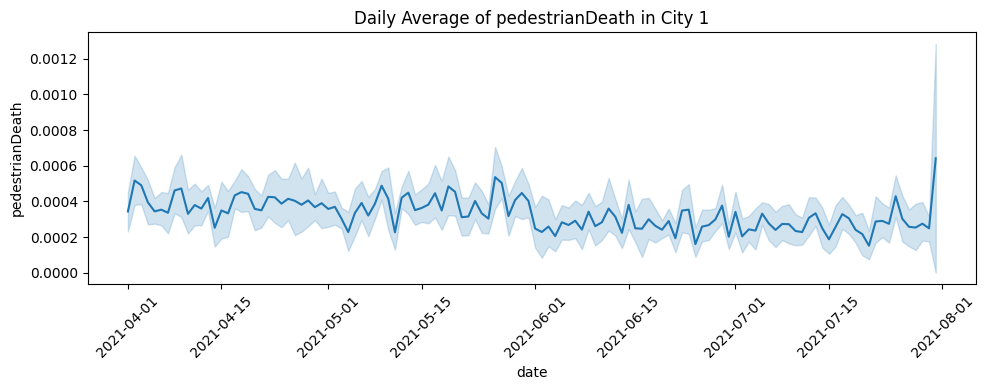

In [ ]:
df_city1 = df[df["city"] == 1].copy()

metrics = ["speed", "energyConsumption", "trafficCongestion", "carCrash", "pedestrianDeath"]

for var in metrics:
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=df_city1, x="date", y=var, estimator="mean")
    plt.title(f"Daily Average of {var} in City 1")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# **Step 4: Visualize speed over time by station (within city 1)**
#### We now explore if all stations in city 1 were affected similarly or not. This will help us see whether the policy impact was localized.

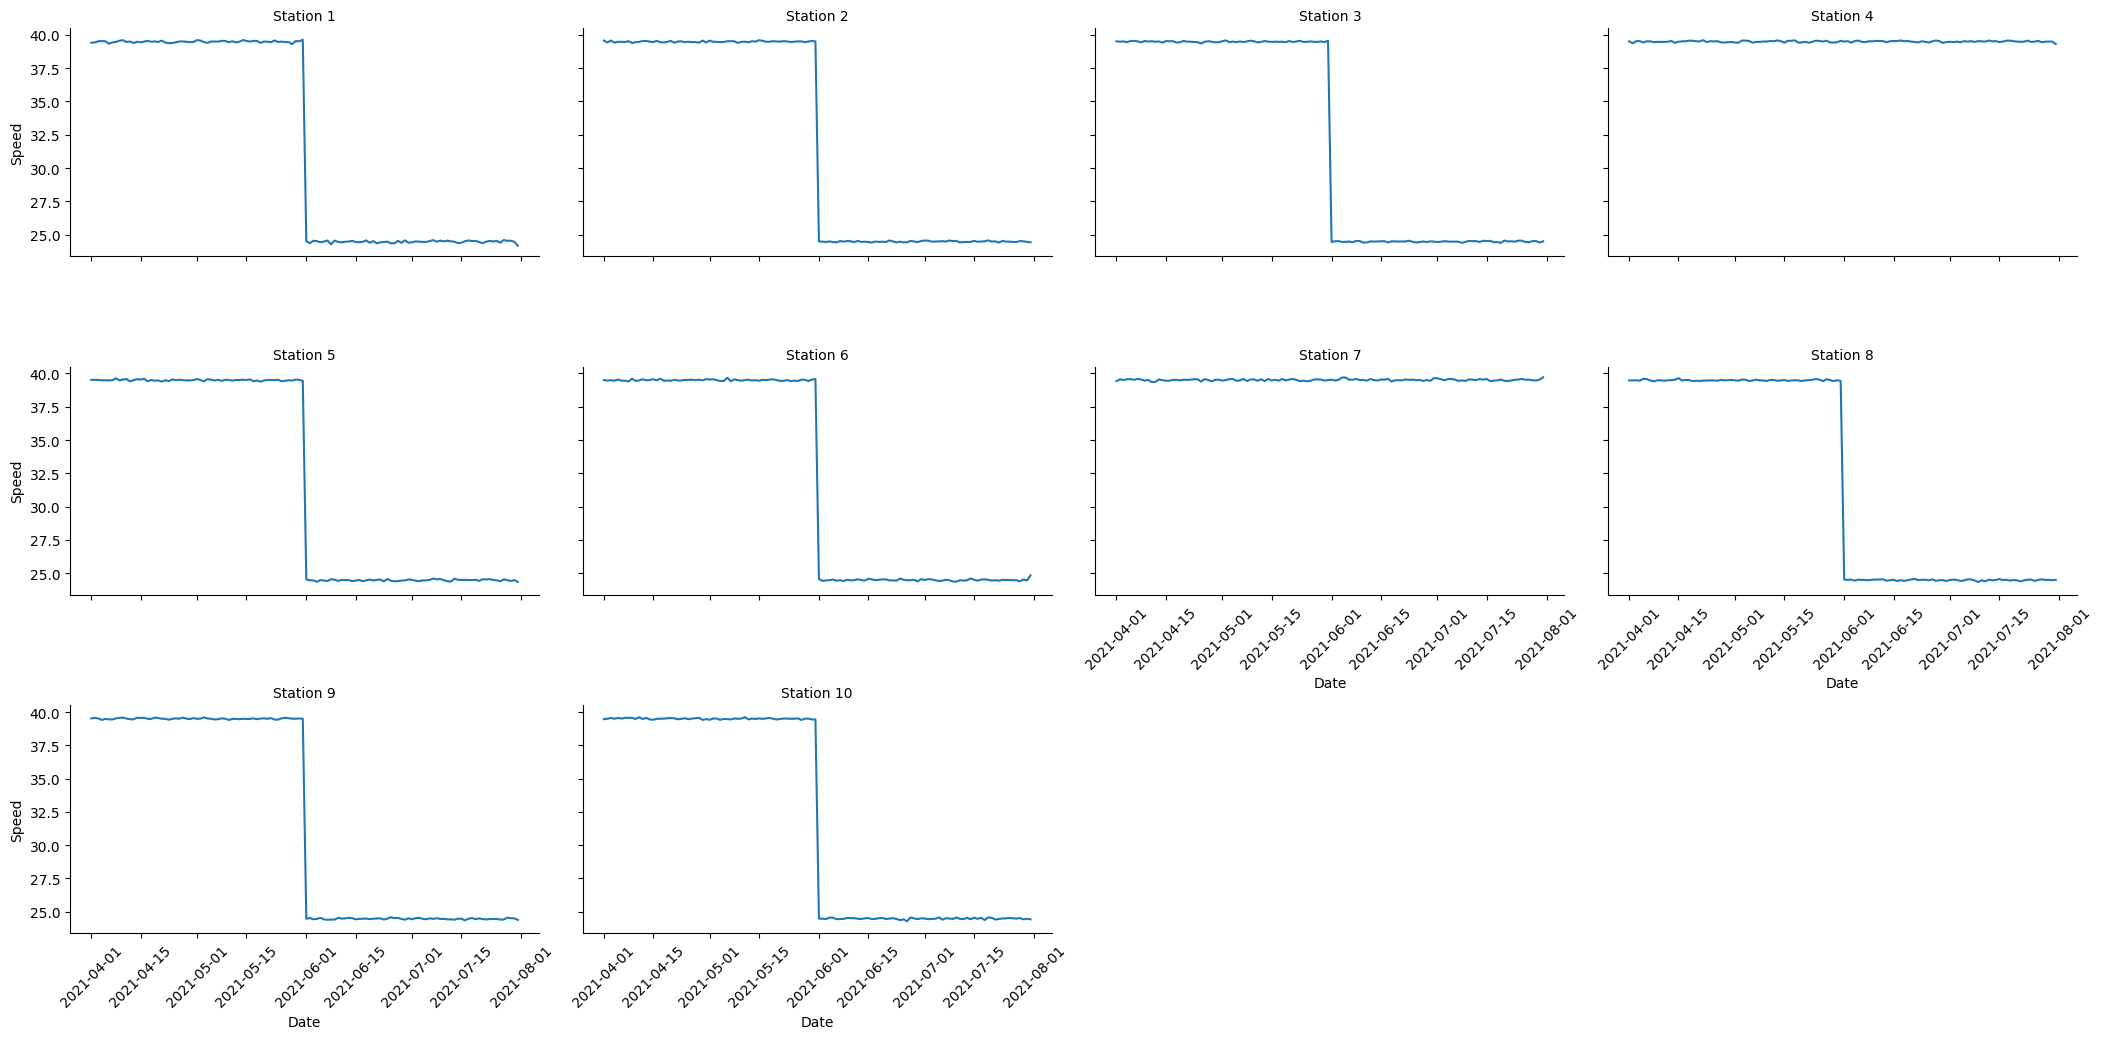

Standard deviation of speed by station in City 1:
station
4     0.052418
7     0.063305
8     7.538212
6     7.541326
10    7.542236
2     7.542259
3     7.543383
1     7.547673
5     7.547738
9     7.550634
Name: speed, dtype: float64


In [ ]:
g = sns.FacetGrid(df_city1, col="station", col_wrap=4, height=3.5, aspect=1.5)
g.map_dataframe(sns.lineplot, x="date", y="speed")
g.set_titles("Station {col_name}")
g.set_axis_labels("Date", "Speed")
for ax in g.axes:
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Variability of speed per station

# Computing the standard deviation of speed per station to quantify which ones had larger behavioral shifts.
station_std = df_city1.groupby("station")["speed"].std().sort_values()

print("Standard deviation of speed by station in City 1:")
print(station_std)

#### We notice that stations 4 and 7 have the lowest variability, suggesting **they might not have been affected by the policy.**


# Step 5: Visualize policy timing relative to speed changes

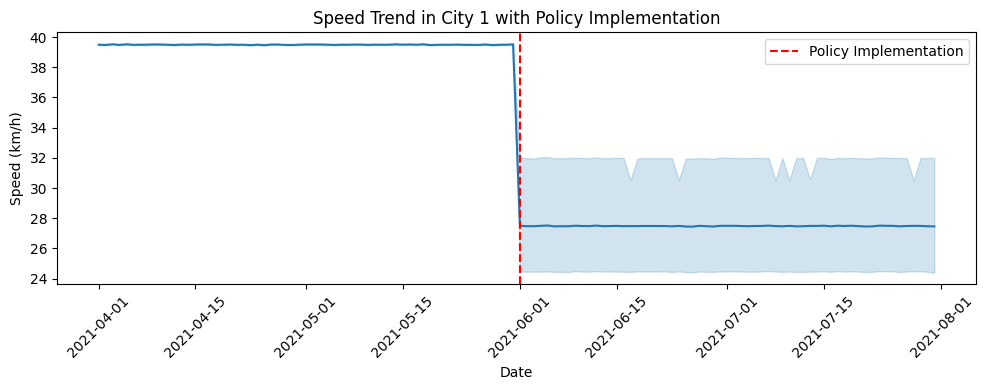

In [ ]:
# Let's overlay the moment the policy was implemented on top of the speed time series.
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_city1, x="date", y="speed")
policy_date = df_city1[df_city1["treated_time"] == 0]["date"].min()
plt.axvline(policy_date, color="red", linestyle="--", label="Policy Implementation")
plt.legend()
plt.title("Speed Trend in City 1 with Policy Implementation")
plt.xlabel("Date")
plt.ylabel("Speed (km/h)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 6: Regression check — Did the policy reduce speed?


#### Before estimating the impact on energy consumption, we first confirm whether the policy actually reduced vehicle speed. This step is important because it sets the causal chain: policy -> speed change -> energy impact.

In [ ]:
# Filter only city 1 and treated stations (treated == 1)
df_city1_treated = df[(df["city"] == 1) & (df["treated"] == 1)].copy()

# Simple regression: speed ~ treated_time
model_speed_treated = smf.ols("speed ~ treated_time", data=df_city1_treated).fit()

print("Speed regression — only treated stations:")
print(model_speed_treated.summary())

Speed regression — only treated stations:
                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     2922.
Date:                Tue, 06 May 2025   Prob (F-statistic):          1.74e-295
Time:                        20:43:55   Log-Likelihood:                -2676.6
No. Observations:                 976   AIC:                             5357.
Df Residuals:                     974   BIC:                             5367.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Interc

####We focus only on the treated stations within city 1, where the policy was actually implemented. The OLS regression reveals a coefficient of -0.1848 for treated_time, with a p-value < 0.001, indicating a strong and statistically significant reduction in average speed after the policy implementation. The R-squared value is 0.75, showing that treated_time alone explains 75% of the variance in speed — an even stronger result than before. This confirms the effectiveness of the policy in reducing vehicle speed exactly where it was applied, reinforcing the first step in our causal chain.

# Step 7: Regression analysis — Did the policy increase energy consumption?


#### Hypothesis: The policy caused vehicles to operate at lower average speeds, which may lead to more frequent deceleration and acceleration. These stop-start dynamics can cause higher energy expenditure compared to maintaining a steady, higher speed. We now test whether treated_time (the policy) had an indirect effect on energyConsumption, controlling for speed and other factors — again, focusing only on treated stations.

In [ ]:
# Multiple regression: energyConsumption ~ treated_time + controls
model_energy_treated = smf.ols(formula="""
    energyConsumption ~ treated_time + speed + trafficCongestion +
    vehicleType + weather + carCrash + pedestrianDeath + dow
""", data=df_city1_treated).fit()

print("Energy consumption regression — only treated stations:")
print(model_energy_treated.summary())

Energy consumption regression — only treated stations:
                            OLS Regression Results                            
Dep. Variable:      energyConsumption   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.518e+07
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:43:55   Log-Likelihood:                 4157.2
No. Observations:                 976   AIC:                            -8296.
Df Residuals:                     967   BIC:                            -8252.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

#### Although the policy did reduce speed significantly (as shown above), the direct effect of treated_time on energy consumption remains statistically insignificant. The coefficient is near zero (-4.41e-06) with a p-value of 0.483, meaning we cannot reject the null hypothesis of no direct effect. However, speed retains a very strong and significant negative relationship with energy consumption (coef = -0.1612, p < 0.001), confirming that lower speeds are consistently associated with higher energy usage. This supports our initial hypothesis: although the policy itself does not directly raise energy use, it indirectly increases it by reducing speed — and reduced speed leads to greater energy consumption due to less efficient driving dynamics in treated zones.

In [ ]:
# Loading main data

try:
    df = pd.read_feather("dailyGrouping.feather")
    print("Main DataFrame loaded.")

except FileNotFoundError:
    print("Error: Check if 'dailyGrouping.feather' file exists in the correct directory.")
    exit()

required_cols = ['treated', 'treated_time', 'speed']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Error: Required columns for DiD analysis not found: {missing_cols}")
    exit()

# Creating 'post' variable: 1 for post-treatment period, 0 for pre-treatment
# Assuming treated_time >= 0 indicates the post-treatment period
df['post'] = (df['treated_time'] >= 0).astype(int)

# Creating 'DiD' interaction term (treated * post)
df['DiD'] = df['treated'] * df['post']

print("'post' and 'DiD' variables created.")

y_col = 'speed'

# Explanatory variables for the basic DiD model
X_cols = ['treated', 'post', 'DiD']

# Selecting only the necessary columns for the DiD model
did_data = df[X_cols + [y_col]].copy()

# Removing rows where any of the selected columns (X or y) have missing values (NaN)
rows_before = did_data.shape[0]
did_data.dropna(inplace=True)
rows_after = did_data.shape[0]
if rows_before > rows_after:
    print(f"Removed {rows_before - rows_after} rows with missing values in DiD model columns ('treated', 'post', 'DiD', 'speed').")

if did_data.shape[0] < 2:
    print("Error: Not enough data to train the DiD model after removing missing values.")
    exit()

X = did_data[X_cols]
y = did_data[y_col]

print(f"\nTraining DiD Model to estimate the treatment effect on '{y_col}'...")

# Creating model instance
model_did = LinearRegression()

# Fiting model using the data
model_did.fit(X, y)
print("Model training complete.")

print("\n=== DiD Regression Results ===")

# Storing coefficients for easier access
coefs = dict(zip(X_cols, model_did.coef_))
intercept = model_did.intercept_

print(f"Outcome variable: {y_col}")
print(f"Intercept: {intercept:+.4f}") # Baseline for control group, pre-treatment
print("Coefficients:")
print(f"  treated: {coefs.get('treated', 0):+.4f}") # Pre-treatment difference btw groups
print(f"  post   : {coefs.get('post', 0):+.4f}") # Time trend for control group
print(f"  DiD    : {coefs.get('DiD', 0):+.4f}  <--- Average Treatment Effect")

did_effect = coefs.get('DiD', 0)
print("\n--- Interpretation ---")
print(f"Estimated Average Treatment Effect (DiD coefficient) on '{y_col}': {did_effect:+.4f}")

if did_effect < -0.01: # Adding a small threshold to avoid printing for near-zero effects
    print(f"(This suggests the treatment led to an average DECREASE in '{y_col}'.)")
elif did_effect > 0.01:
     print(f"(This suggests the treatment led to an average INCREASE in '{y_col}'.)")
else:
     print(f"(The estimated treatment effect on '{y_col}' is close to zero.)")

Main DataFrame loaded.
'post' and 'DiD' variables created.

Training DiD Model to estimate the treatment effect on 'speed'...
Model training complete.

=== DiD Regression Results ===
Outcome variable: speed
Intercept: +39.5007
Coefficients:
  treated: -0.0045
  post   : +0.0021
  DiD    : -15.0281  <--- Average Treatment Effect

--- Interpretation ---
Estimated Average Treatment Effect (DiD coefficient) on 'speed': -15.0281
(This suggests the treatment led to an average DECREASE in 'speed'.)


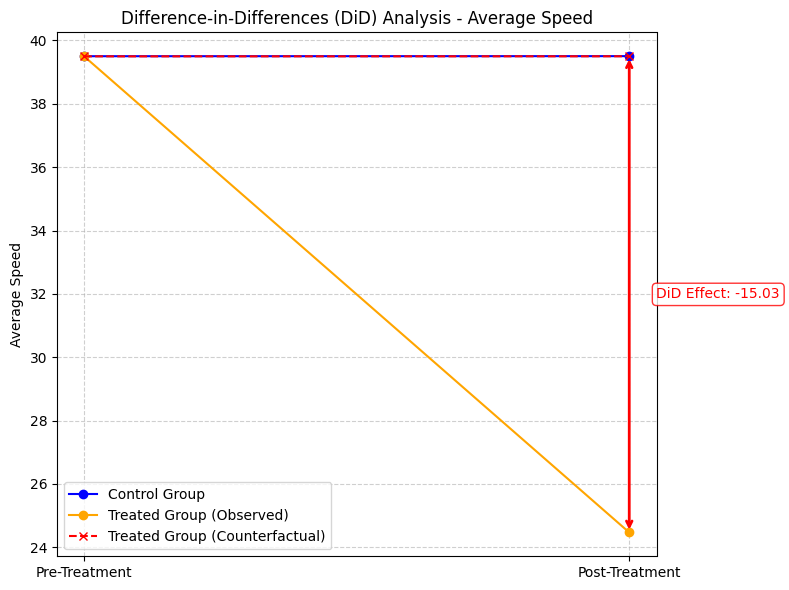


Visually Calculated DiD Effect: -15.0281


In [ ]:
try:
    # Reload or use the existing 'df' from the previous step
    if 'df' not in locals(): # Check if df exists, otherwise try to load
         df_main = pd.read_feather("dailyGrouping.feather")
         df = df_main.copy()

         if 'treated_time' in df.columns:
              df['post'] = (df['treated_time'] >= 0).astype(int)
         else:
              print("Error: 'treated_time' column needed to create 'post'.")
              exit()
         print("DataFrame loaded and 'post' variable created/verified.")

    # Checking for required columns
    required_cols_plot = ['speed', 'treated', 'post']
    if not all(col in df.columns for col in required_cols_plot):
         print(f"Error: Missing required columns for plot: {required_cols_plot}")
         exit()

except NameError:
     print("Error: DataFrame 'df' not found. Run the loading steps first.")
     exit()
except FileNotFoundError:
    print("Error: 'dailyGrouping.feather' file not found.")
    exit()


# Grouping by period (post) and grouping (treated) and calculating the mean of 'speed'
avg_speed = df.groupby(['post', 'treated'])['speed'].mean().unstack()

# Checking if we have all 4 groups (pre/post for control/treated)
if avg_speed.shape != (2, 2) or avg_speed.isnull().any().any():
     print("Warning: Could not calculate averages for all 4 groups (pre/post x control/treated). Check your data.")

     print("Calculated averages:\n", avg_speed)



# Control (treated=0), Treated (treated=1)
# Pre (post=0), Post (post=1)
try:
    control_pre = avg_speed.loc[0, 0] # Avg Control, Pre
    control_post = avg_speed.loc[1, 0] # Avg Control, Post
    treated_pre = avg_speed.loc[0, 1] # Avg Treated, Pre
    treated_post = avg_speed.loc[1, 1] # Avg Treated, Post
except KeyError as e:
    print(f"Error accessing calculated averages. Check if all groups exist. Missing key: {e}")
    print("Calculated averages:\n", avg_speed)
    exit()


# Trend in the control group
control_trend = control_post - control_pre

# Counterfactual: Where the treated group would have ended up if it followed the control group's trend
counterfactual_treated_post = treated_pre + control_trend

# DiD Effect
did_effect_visual = treated_post - counterfactual_treated_post


fig, ax = plt.subplots(figsize=(8, 6))

# Control Group (Blue)
ax.plot([0, 1], [control_pre, control_post], marker='o', linestyle='-', color='blue', label='Control Group')
# Treated Group (Orange)
ax.plot([0, 1], [treated_pre, treated_post], marker='o', linestyle='-', color='orange', label='Treated Group (Observed)')

# Line for Counterfactual (Dashed Red)
ax.plot([0, 1], [treated_pre, counterfactual_treated_post], marker='x', linestyle='--', color='red', label='Treated Group (Counterfactual)')



mid_point_x = 1

y_arrow_start = counterfactual_treated_post
y_arrow_end = treated_post

# DiD Effect
ax.annotate(
    '', xy=(mid_point_x, y_arrow_end), xycoords='data',
    xytext=(mid_point_x, y_arrow_start), textcoords='data',
    arrowprops=dict(arrowstyle="<->", color='red', lw=2),
    va='center'
)

ax.annotate(
    f'DiD Effect: {did_effect_visual:.2f}', # Text with the calculated value
    xy=(mid_point_x + 0.05, (y_arrow_start + y_arrow_end) / 2), # Position of the text
    xycoords='data',
    textcoords='data',
    color='red',
    va='center',
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", lw=1, alpha=0.8) # Text box
)


ax.set_xticks([0, 1])
ax.set_xticklabels(['Pre-Treatment', 'Post-Treatment'])
ax.set_ylabel('Average Speed')
ax.set_title('Difference-in-Differences (DiD) Analysis - Average Speed')
ax.legend(loc='best')
ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

print(f"\nVisually Calculated DiD Effect: {did_effect_visual:.4f}")


=== Event study for Traffic Congestion ===


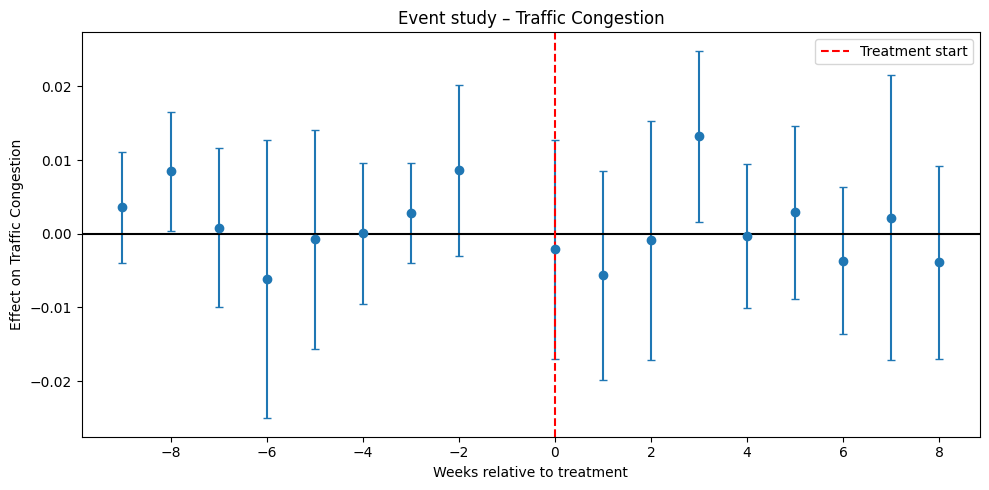

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 9
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.0725,0.003,709.273,0.000,2.067,2.078
C(station)[T.2],-0.0404,9.24e-15,-4.37e+12,0.000,-0.040,-0.040
C(station)[T.3],0.1925,2.37e-14,8.12e+12,0.000,0.193,0.193
C(station)[T.4],0.2273,1.81e-14,1.26e+13,0.000,0.227,0.227
C(station)[T.5],0.0275,1.43e-14,1.92e+12,0.000,0.028,0.028
C(station)[T.6],0.2666,1.53e-14,1.75e+13,0.000,0.267,0.267
C(station)[T.7],-0.0259,1.13e-14,-2.28e+12,0.000,-0.026,-0.026
C(station)[T.8],0.2647,1.44e-14,1.83e+13,0.000,0.265,0.265
C(station)[T.9],0.2183,1.56e-14,1.4e+13,0.000,0.218,0.218
C(station)[T.10],-0.0173,1.22e-14,-1.42e+12,0.000,-0.017,-0.017



=== Event study for Car Crashes ===


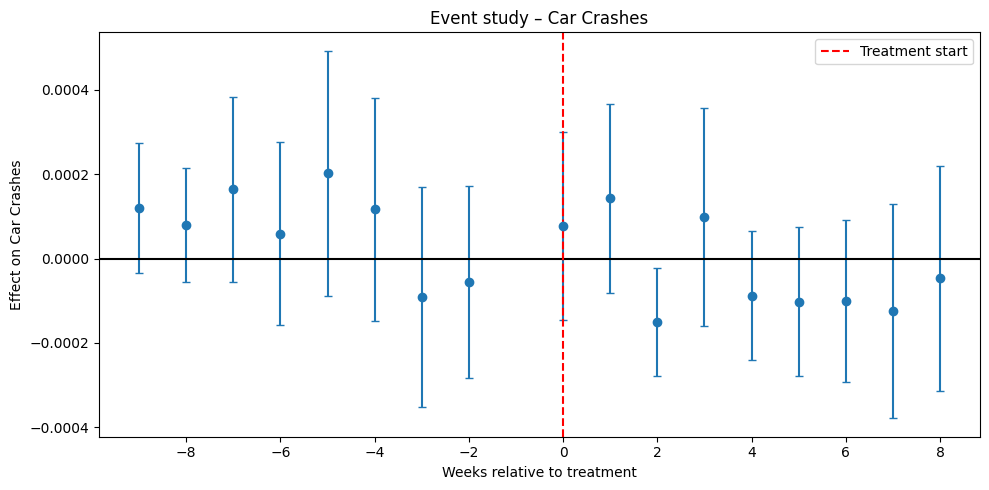

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 9
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.0019,2.32e-05,83.494,0.000,0.002,0.002
C(station)[T.2],1.774e-05,5.15e-18,3.45e+12,0.000,1.77e-05,1.77e-05
C(station)[T.3],0.0003,1.72e-17,1.61e+13,0.000,0.000,0.000
C(station)[T.4],0.0003,1.22e-17,2.77e+13,0.000,0.000,0.000
C(station)[T.5],9.913e-05,9.25e-18,1.07e+13,0.000,9.91e-05,9.91e-05
C(station)[T.6],0.0003,1.02e-17,3.14e+13,0.000,0.000,0.000
C(station)[T.7],7.934e-05,5.77e-18,1.38e+13,0.000,7.93e-05,7.93e-05
C(station)[T.8],0.0003,9.42e-18,3.1e+13,0.000,0.000,0.000
C(station)[T.9],0.0003,9.48e-18,2.67e+13,0.000,0.000,0.000
C(station)[T.10],6.682e-05,7.21e-18,9.26e+12,0.000,6.68e-05,6.68e-05



=== Event study for Pedestrian Deaths ===


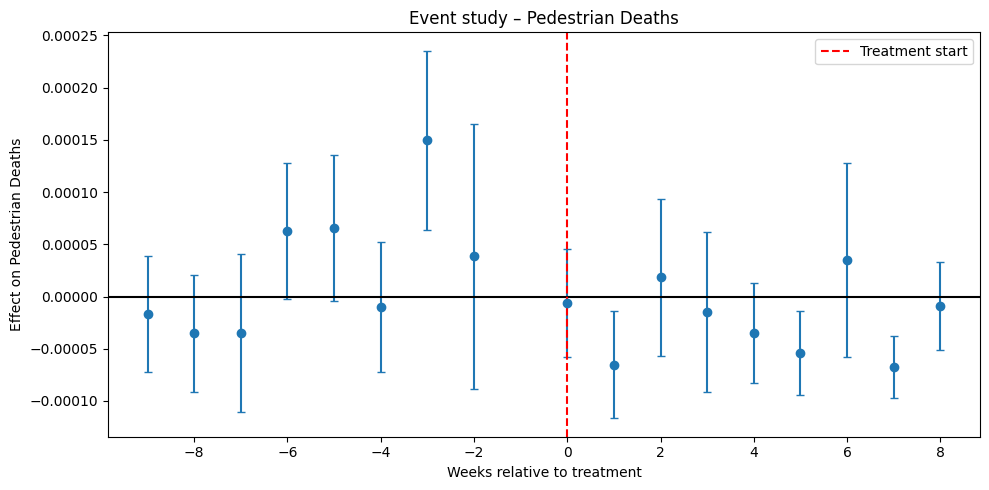

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 9
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,0.0003,9.56e-06,26.327,0.000,0.000,0.000
C(station)[T.2],9.363e-07,8.45e-19,1.11e+12,0.000,9.36e-07,9.36e-07
C(station)[T.3],3.637e-05,2.28e-18,1.59e+13,0.000,3.64e-05,3.64e-05
C(station)[T.4],4.589e-05,1.74e-18,2.64e+13,0.000,4.59e-05,4.59e-05
C(station)[T.5],3.789e-07,1.29e-18,2.94e+11,0.000,3.79e-07,3.79e-07
C(station)[T.6],4.004e-05,1.47e-18,2.73e+13,0.000,4e-05,4e-05
C(station)[T.7],1.758e-05,9.95e-19,1.77e+13,0.000,1.76e-05,1.76e-05
C(station)[T.8],2.958e-05,1.44e-18,2.05e+13,0.000,2.96e-05,2.96e-05
C(station)[T.9],2.874e-05,1.22e-18,2.36e+13,0.000,2.87e-05,2.87e-05
C(station)[T.10],1.011e-05,1.08e-18,9.35e+12,0.000,1.01e-05,1.01e-05



=== Event study for Speed ===


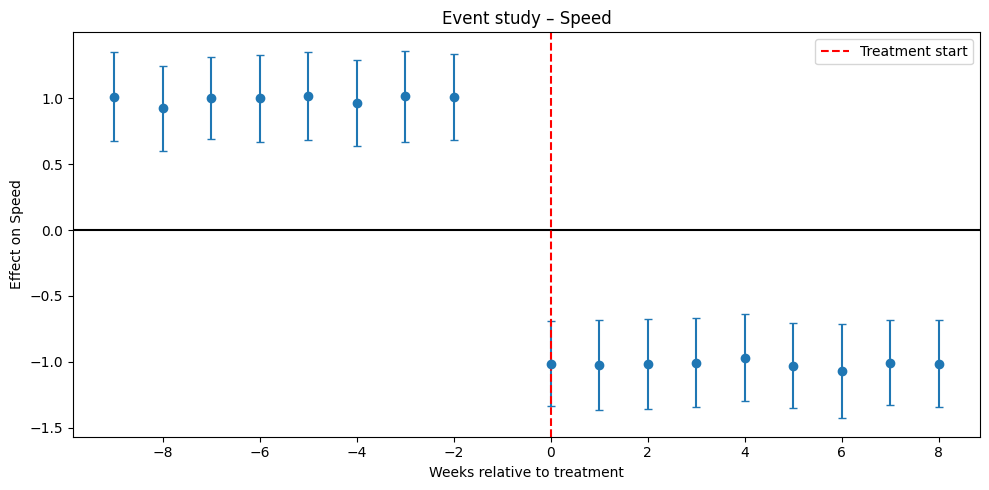

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 9
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,38.3113,0.013,2972.821,0.000,38.286,38.337
C(station)[T.2],0.0049,1.22e-13,4.03e+10,0.000,0.005,0.005
C(station)[T.3],-0.0035,3.67e-13,-9.52e+09,0.000,-0.003,-0.003
C(station)[T.4],1.2616,2.64e-13,4.78e+12,0.000,1.262,1.262
C(station)[T.5],0.0078,2.22e-13,3.51e+10,0.000,0.008,0.008
C(station)[T.6],0.0033,2.32e-13,1.43e+10,0.000,0.003,0.003
C(station)[T.7],1.2645,1.78e-13,7.11e+12,0.000,1.264,1.264
C(station)[T.8],0.0031,2.41e-13,1.3e+10,0.000,0.003,0.003
C(station)[T.9],-0.0036,1.95e-13,-1.86e+10,0.000,-0.004,-0.004
C(station)[T.10],0.0023,1.63e-13,1.41e+10,0.000,0.002,0.002



=== Event study for Energy Consumption ===


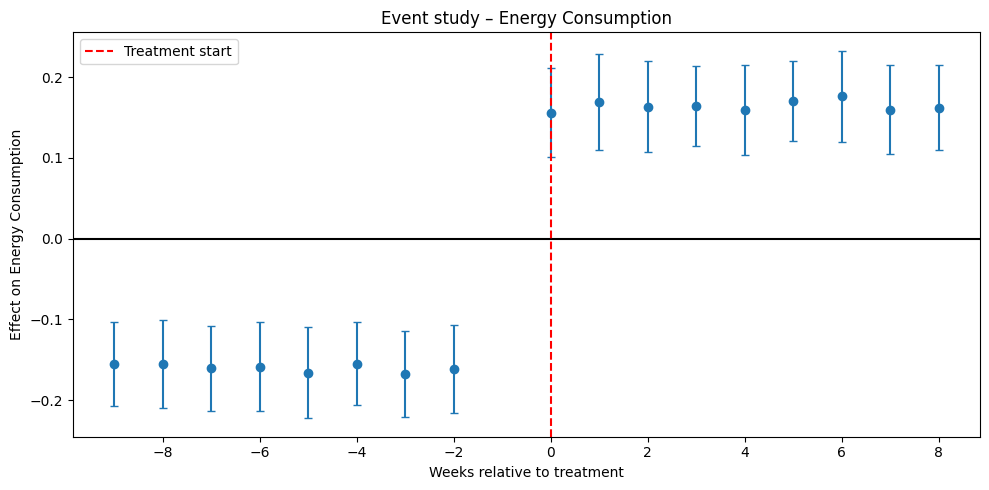

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 32, but rank is 9
  warnings.warn('covariance of constraints does not have full '


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,8.7594,0.002,4218.435,0.000,8.755,8.763
C(station)[T.2],-0.0009,3.02e-14,-3e+10,0.000,-0.001,-0.001
C(station)[T.3],-0.0031,7.86e-14,-3.9e+10,0.000,-0.003,-0.003
C(station)[T.4],-0.2025,5.77e-14,-3.51e+12,0.000,-0.203,-0.203
C(station)[T.5],-0.0012,5.18e-14,-2.3e+10,0.000,-0.001,-0.001
C(station)[T.6],0.0013,4.63e-14,2.89e+10,0.000,0.001,0.001
C(station)[T.7],-0.2040,4.38e-14,-4.65e+12,0.000,-0.204,-0.204
C(station)[T.8],-9.719e-06,5.79e-14,-1.68e+08,0.000,-9.72e-06,-9.72e-06
C(station)[T.9],-0.0009,4.65e-14,-1.92e+10,0.000,-0.001,-0.001
C(station)[T.10],5.887e-05,4.14e-14,1.42e+09,0.000,5.89e-05,5.89e-05


In [ ]:
import statsmodels.formula.api as smf
from matplotlib.ticker import MaxNLocator

PRETTY = {
    'trafficCongestion': 'Traffic Congestion',
    'carCrash':          'Car Crashes',
    'pedestrianDeath':   'Pedestrian Deaths',
    'speed':             'Speed',
    'energyConsumption': 'Energy Consumption'
}

def _d(k):
    return f'd_m{abs(k)}' if k < 0 else f'd{k}'

def coefplot(df, y, leads=9, lags=8, cluster='station',
             fe_station=True, fe_dow=True):

    df = df.copy()
    for k in range(-leads, lags + 1):
        if k != -1:
            df[_d(k)] = (df['treated_time'] == k).astype(int)

    dummies = " + ".join([_d(k) for k in range(-leads, lags + 1) if k != -1])
    fe = []
    if fe_station: fe.append("C(station)")
    if fe_dow and 'dow' in df.columns: fe.append("C(dow)")
    formula = f"{y} ~ {dummies}" + (" + " + " + ".join(fe) if fe else "")

    model = smf.ols(formula, data=df).fit(
        cov_type='cluster', cov_kwds={'groups': df[cluster]}
    )

    ks, coef, low, up = [], [], [], []
    for k in range(-leads, lags + 1):
        if k == -1: continue
        term = _d(k)
        if term in model.params.index:
            ks.append(k)
            coef.append(model.params[term])
            low.append(model.conf_int().loc[term, 0])
            up.append(model.conf_int().loc[term, 1])

    pretty = PRETTY.get(y, y)

    plt.figure(figsize=(10, 5))
    plt.errorbar(ks, coef,
                 yerr=[np.array(coef) - np.array(low),
                       np.array(up) - np.array(coef)],
                 fmt='o', capsize=3)
    plt.axhline(0, color='black')
    plt.axvline(0, color='red', linestyle='--', label='Treatment start')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('Weeks relative to treatment')
    plt.ylabel(f'Effect on {pretty}')
    plt.title(f'Event study – {pretty}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return model

outcomes = ['trafficCongestion', 'carCrash', 'pedestrianDeath',
            'speed', 'energyConsumption']

for y in outcomes:
    print(f"\n=== Event study for {PRETTY[y]} ===")
    m = coefplot(df, y, leads=9, lags=8)
    display(m.summary().tables[1])

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df= pd.read_feather("dataset/dailyGrouping.feather")
df_traffic=pd.read_csv("info/trafficLevels.csv")

df_traffic = pd.read_csv("info/trafficLevels.csv", index_col=0)
df_traffic_long = df_traffic.T.reset_index().melt(id_vars='index', var_name='city', value_name='trafficLevel')
df_traffic_long = df_traffic_long.rename(columns={'index': 'station'})#Adaptation of traffic data for merging with general dataset.

df_traffic_long['city'] = df_traffic_long['city'].astype(int)
df_traffic_long['station'] = df_traffic_long['station'].astype(int)

df_cities=pd.read_csv("info/cityInfo.csv")
df['weather']=(df["weather"]*2).round()/2
df = df.merge(df_cities[['city', 'popDensity','population','size']], on='city', how='left')
df=df.merge(df_traffic_long[['city','station','trafficLevel']],on=['city','station'],how='left')
df['log_popDensity']=np.log(df['popDensity'])

In [ ]:
df_polApp=df[(df['treated']==1)]
df_polNA=df[df['treated']==0] #Separating the stations where the policy has been applied
print("The stations where the policy was applied are:")
print(df_polApp[['city','station']].drop_duplicates().to_string(index=False)) #Stations where the policy was applied

In [ ]:
df_1_1=df_polApp[(df_polApp['city']==1)&(df_polApp['station']==10)]
df_1_2=df_polNA[(df_polNA['city']==1)&(df_polNA['station']==4)]

In [ ]:
from matplotlib.ticker import MaxNLocator

df_1_1['date_str'] = df_1_1['date'].dt.strftime('%m-%d')
df_1_2['date_str'] = df_1_2['date'].dt.strftime('%m-%d')
treatment_start=df_1_1[df_1_1['treated_time']==0]['date'].iloc[0]
treatment_start_str=treatment_start.strftime('%m-%d')
plt.figure(figsize=(10,6))
plt.plot(df_1_1['date_str'],df_1_1['speed'],marker='o',label='Stations with treatment')
plt.plot(df_1_2['date_str'],df_1_2['speed'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average speed')
plt.title('Average Speed vs Treated Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.axvline(treatment_start_str,color='red',label='Treatment Start')
plt.legend()
print("The maximum speed without new policy is:",df_polNA['speed'].max().round())
print("The maximum speed with new policy is:",df_polApp[df_polApp['treated_time']>0]['speed'].max().round())

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df_1_1['date_str'],df_1_1['energyConsumption'],marker='o',label='Stations with treatment')
plt.plot(df_1_2['date_str'],df_1_2['energyConsumption'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Energy Consumption')
plt.title('Average Energy Consumption vs Treated Time')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.axvline(treatment_start_str,color='red',label='Treatment Start')
plt.legend()


print("The maximum speed without new policy is:",df_polNA['energyConsumption'].max().round(1))
print("The maximum speed with new policy is:",df_polApp[df_polApp['treated_time']>0]['energyConsumption'].max().round(1))

In [ ]:
group_variance = df_polApp.groupby(['city', 'station'])['trafficCongestion'].transform('var')
df_polApp['trafficVariance'] = group_variance
group_variance = df_polNA.groupby(['city', 'station'])['trafficCongestion'].transform('var')
df_polNA['trafficVariance'] = group_variance

df_polNA_1=df_polNA[df_polNA['trafficVariance']>0]
df_polApp_1=df_polApp[df_polApp['trafficVariance']>0]#Getting rid of stations with constant data in traffic congestion.

In [ ]:
df_polApp_avg=df_polApp.groupby('treated_time').mean().reset_index()#For car crashes and pedestrian death analysis
df_polNA_avg=df_polNA.groupby('treated_time').mean().reset_index()
df_polApp_avg_1=df_polApp_1.groupby('treated_time').mean().reset_index()#For traffic analysis
df_polNA_avg_1=df_polNA_1.groupby('treated_time').mean().reset_index()
plt.figure(figsize=(10,6))
plt.plot(df_polApp_avg_1['treated_time'],df_polApp_avg_1['trafficCongestion'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg_1['treated_time'],df_polNA_avg_1['trafficCongestion'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Traffic Congestion')
plt.title('Average Traffic Congestion vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()


In [ ]:
df_polApp_avg_1["traffic_standardized"] = (df_polApp_avg_1["trafficCongestion"] - df_polApp_avg_1["trafficCongestion"].mean()) / df_polApp_avg_1["trafficCongestion"].std()
df_polNA_avg_1["traffic_standardized"] = (df_polNA_avg_1["trafficCongestion"] - df_polNA_avg_1["trafficCongestion"].mean()) / df_polNA_avg_1["trafficCongestion"].std()
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg_1['treated_time'],df_polApp_avg_1['traffic_standardized'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg_1['treated_time'],df_polNA_avg_1['traffic_standardized'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Standardized Traffic Congestion')
plt.title('Standardized Traffic Congestion vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [ ]:
import statsmodels.formula.api as smf

df_polApp_1["group"] = 1  # treated
df_polNA_1["group"] = 0  # control   For traffic analysis

df_polApp["group"] = 1  # treated
df_polNA["group"] = 0  # control     For car crashes and pedestrian death analysis

df_all = pd.concat([df_polApp_1, df_polNA_1], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

# Difference-in-Differences regression
model = smf.ols("trafficCongestion ~ group + post + group:post + log_popDensity + size +C(trafficLevel)+C(dow)+C(weather)", data=df_all).fit(cov_type='HC3')
print(len(df_all))
model.summary()

The R^2 of 0.701 implies that the model is pretty accurate, but the group:post DiD coefficient is very close to 0, and more important, the p-value (0.972) is too big, so the treatment didn't actually have an impact in traffic congestion

In [ ]:
import seaborn as sns

predictions=model.get_prediction(df_all)

df_all['predictedTraffic']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8)) | ((df_all['city']==4) & (df_all['station']==1))]

df_all_1['group_label']=df_all_1['group'].map({0:"Control",1:"Treated"})
df_all_1["period"] = df_all_1["post"].map({0: "Before", 1: "After"})
df_all_1 = df_all_1.dropna(subset=['predictedTraffic', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all_1[df_all_1['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedTraffic'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Traffic', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all_1[df_all_1['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedTraffic'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Traffic', color='green')

# Treatment start line
treatment_start = df_all_1[df_all_1['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Traffic Congestion (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

In [ ]:
df_all = pd.concat([df_polApp, df_polNA], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

df_all_1=df_all[((df_all['city']==1) & (df_all['station']==10))]
df_all_2=df_all[((df_all['city']==6) & (df_all['station']==4))]

plt.figure(figsize=(10, 6))
plt.plot(df_all_1['treated_time'],df_all_1['carCrash'],marker='o',label='Stations with treatment')
plt.plot(df_all_2['treated_time'],df_all_2['carCrash'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Car crashes')
plt.title('Car crashes vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [ ]:
model = smf.ols("carCrash ~ group + post + group:post + size + log_popDensity + C(trafficLevel)  + C(weather) +C(dow)", data=df_all).fit(cov_type='HC3')

model.summary()

The R^2 of 0.416 implies that the model is a little accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.01, so the treatment had a big impact in the frequency of car crashes.

In [ ]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8))]
df_all_2=df_all[((df_all['city']==4) & (df_all['station']==1))]

predictions=model.get_prediction(df_all)

df_all['predictedCrashes']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedCrashes', 'ci_lower', 'ci_upper'])


In [ ]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8)) | ((df_all['city']==6) & (df_all['station']==6))]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all_1[df_all_1['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedCrashes'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Car Crashes', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all_1[df_all_1['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedCrashes'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Car Crashes', color='green')

# Treatment start line
treatment_start = df_all_1[df_all_1['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Car Crashes (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

In [ ]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8))]
df_all_2=df_all[((df_all['city']==6) & (df_all['station']==1))]

plt.figure(figsize=(10, 6))
plt.plot(df_all_1['treated_time'],df_all_1['pedestrianDeath'],marker='o',label='Stations with treatment')
plt.plot(df_all_2['treated_time'],df_all_2['pedestrianDeath'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Pedestrian deaths')
plt.title('Pedestrian deaths vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [ ]:
model = smf.ols("pedestrianDeath ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

The R^2 of 0.009 implies that the model is not very accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.000, so the treatment had a clear impact in the frequency of pedestrian deaths.

In [ ]:
df_all_1=df_all[((df_all['city']==1) & (df_all['station']==8)) | ((df_all['city']==6) & (df_all['station']==6))]

predictions=model.get_prediction(df_all_1)

df_all_1['predictedPedestrianDeath']=predictions.predicted_mean
df_all_1['ci_lower'],df_all_1['ci_upper']=predictions.conf_int().T

df_all_1['group_label']=df_all_1['group'].map({0:"Control",1:"Treated"})
df_all_1["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all_1 = df_all_1.dropna(subset=['predictedPedestrianDeath', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all_1[df_all_1['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedPedestrianDeath'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Pedestrian Deaths', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all_1[df_all_1['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedPedestrianDeath'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Pedestrian Deaths', color='green')

# Treatment start line
treatment_start = df_all_1[df_all_1['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Pedestrian Deaths (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

In [ ]:
#Now we'll do the same analysis for the averages of car crashes and pedestrian deaths averages.

plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['carCrash'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['carCrash'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average Car crashes')
plt.title('Average Car crashes vs Treated Time')
plt.grid(True)
plt.axvline(0,color='red',label='Treatment Start')
plt.legend()

In [ ]:
df_polApp_avg["group"] = 1  # treated
df_polNA_avg["group"] = 0  # control

df_all = pd.concat([df_polApp_avg, df_polNA_avg], ignore_index=True)

df_all["post"] = df_all["treated_time"] >= 0

model = smf.ols("carCrash ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

The R^2 of 0.888 implies that the model is pretty accurate, and the group:post DiD coefficient is very close to 0, but, the p-value (0.00) is lower than 0.000, so the treatment had a big impact in the frequency of car crashes.

In [ ]:
predictions=model.get_prediction(df_all)

df_all['predictedCrashes']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedCrashes', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedCrashes'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Average Car Crashes', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedCrashes'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Average Car Crashes', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Average Car Crashes (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_polApp_avg['treated_time'],df_polApp_avg['pedestrianDeath'],marker='o',label='Stations with treatment')
plt.plot(df_polNA_avg['treated_time'],df_polNA_avg['pedestrianDeath'],marker='o', label='Stations without treatment')
plt.xlabel('Treated Time')
plt.ylabel('Average pedestrian deaths')
plt.title('Average pedestrian deaths vs Treated Time')
plt.axvline(0,color='red',label='Treatment Start')
plt.grid(True)
plt.legend()

In [ ]:
model = smf.ols("pedestrianDeath ~ group + post + group:post + C(dow)", data=df_all).fit()

print(model.summary())

The R^2 of 0.462 implies that the model is decently accurate, and although the group:post DiD coefficient is very close to 0, the p-value (0.00) is lower than 0.000, so the treatment had a clear impact in the frequency of pedestrian deaths.

In [ ]:
predictions=model.get_prediction(df_all)

df_all['predictedPedestrianDeath']=predictions.predicted_mean
df_all['ci_lower'],df_all['ci_upper']=predictions.conf_int().T

df_all['group_label']=df_all['group'].map({0:"Control",1:"Treated"})
df_all["period"] = df_all["post"].map({0: "Before", 1: "After"})
df_all = df_all.dropna(subset=['predictedPedestrianDeath', 'ci_lower', 'ci_upper'])

fig, ax1 = plt.subplots(figsize=(12, 6))

# Treated group (left y-axis)
treated_data = df_all[df_all['group_label'] == 'Treated']
ax1.plot(treated_data['date'], treated_data['predictedPedestrianDeath'], color='blue', label='Treated')
ax1.fill_between(treated_data['date'], treated_data['ci_lower'], treated_data['ci_upper'], alpha=0.2, color='blue')
ax1.set_ylabel('Treated Predicted Pedestrian deaths', color='blue')

# Control group (right y-axis)
ax2 = ax1.twinx()
control_data = df_all[df_all['group_label'] == 'Control']
ax2.plot(control_data['date'], control_data['predictedPedestrianDeath'], color='green', label='Control')
ax2.fill_between(control_data['date'], control_data['ci_lower'], control_data['ci_upper'], alpha=0.2, color='green')
ax2.set_ylabel('Control Predicted Pedestrian deaths', color='green')

# Treatment start line
treatment_start = df_all[df_all['treated_time'] == 0]['date'].iloc[0]
ax1.axvline(treatment_start, color='red', linestyle='--', label='Treatment Start')

fig.tight_layout()
plt.title('Predicted Average Pedestrian Deaths (95% C.I.) (Dual Y-Axis)')
fig.legend(loc='upper right')
plt.show()